In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import torch

## for bert language model
import transformers
from transformers import AutoTokenizer, AutoModel

In [2]:
''' The following shows the result of training various non-neural network models on an augmented version of the 
tamil set so that the negative label is as close as posible to the positive label. models are trained on an bert vectorizer'''

' The following shows the result of training various non-neural network models on an augmented version of the \ntamil set so that the negative label is as close as posible to the positive label. models are trained on an bert vectorizer'

In [3]:
# import data
tam_train = pd.read_table("../../datasets/task_a/tam_train_negative_augmented.tsv")
tam_dev = pd.read_table("../../datasets/task_a/tam_sentiment_dev.tsv")

In [4]:
tam_train = tam_train.rename(columns={'category': 'y'})
tam_dev = tam_dev.rename(columns={'category': 'y'})

In [5]:
tam_dev

,text,y
0,@0:40 songsuperb..kamallllla.. I'm waiting fo...,unknown_state
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive
2,Thalavia neenga veera level boss and neega tha...,Positive
3,Oru padam patha fell.vera level music,Positive
4,Hairstyle than mattama iruku. Adhu mattum math...,unknown_state
...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு. இதை தான் இந்த படம்...,Positive
3958,So long to see you suriya,not-Tamil
3959,Super sK ettan adipoli makkalle dec20 waiti...,Mixed_feelings
3960,Minimum 50m viewa vara veppoma all thala fans,Positive


In [6]:
tam_train

,text,y
0,மோசமான = ராஜா-கியம்பேஸ்ட் = பிரஜா-கேயா,Negative
1,ethula oru padam nu trailer tavaiya sunny pund...,Negative
2,Pora pokku la Rajini ooti vittu teengalae!!🤣🤣🤣,unknown_state
3,Super star Super star Super star super Super s...,Positive
4,நாடார் இனத்தின் சார்பாக படம் வெற்றியடைய வாழ்த்...,Positive
...,...,...
38944,Nethaan ennoda thala unna ethirtha velum kola,Positive
38945,Super Anna idhu idhu idhu beku,Positive
38946,இந்த படத்தை அனைவரும் கண்டிப்பாக பார்க்க வேண்டி...,Positive
38947,Semayana oru Matter iruku intha movie la,Negative


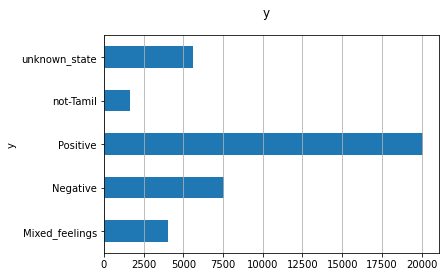

In [7]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
tam_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [8]:
# Now we can define our training data and our dev data as well as targets
train = tam_train
test = tam_dev

y_train = tam_train['y'].values
y_test = tam_dev['y'].values


# Gettint text embeddings from the bert model

In [9]:
# I'll be using the embeddings from the multilinngual bert model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = AutoModel.from_pretrained('bert-base-multilingual-uncased').to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# We will start by gathering the embeddings for the validation set
cls_val_list = []
batch_size = 1000

for batch_number, batch_test in test.groupby(np.arange(len(test)) // batch_size):
    # tokanizing the text
    tokenized_val = tokenizer(batch_test["text"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_val = model(**tokenized_val)
            
    #get only the [CLS] hidden states
    cls_val = hidden_val.last_hidden_state[:,0,:]
    cls_val = cls_val.to("cpu")
    cls_val_list.append(cls_val)
    del cls_val
    del hidden_val
    del tokenized_val
    
    torch.cuda.empty_cache()

cls_val_list_final = []
for i in range(len(cls_val_list)):
    for j in range(len(cls_val_list[i])):
        cls_val_list_final.append(cls_val_list[i][j])

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# Get embeddigns for the trainins set
cls_train_list = []
batch_size = 1000

for batch_number, batch_train in train.groupby(np.arange(len(train)) // batch_size):
    # tokanizing the text
    tokenized_train = tokenizer(batch_train["text"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_train = model(**tokenized_train)
            
    #get only the [CLS] hidden states
    cls_train = hidden_train.last_hidden_state[:,0,:]
    cls_train = cls_train.to("cpu")
    cls_train_list.append(cls_train)
    del cls_train
    del hidden_train
    del tokenized_train
    
    torch.cuda.empty_cache()

cls_train_list_final = []
for i in range(len(cls_train_list)):
    for j in range(len(cls_train_list[i])):
        cls_train_list_final.append(cls_train_list[i][j])

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [12]:
len(cls_val_list_final)

3962

In [13]:
len(cls_train_list_final)

38949

In [ ]:
X_train = torch.stack(cls_train_list_final)
X_train = pd.DataFrame(X_train)
X_test = torch.stack(cls_val_list_final)
X_test = pd.DataFrame(X_test)

y_train = kan_train['y'].values
y_test = kan_dev['y'].values

# Training a cat boost classifier

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(
    iterations=180, 
    learning_rate=.8, 
    #loss_function='CrossEntropy'
)


In [ ]:
## train classifier
cat.fit(X_train, y_train)
predicted = cat.predict(X_test)

predicted_prob = cat.predict_proba(X_test)

In [ ]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=150, n_estimators=15, max_features=768)

In [ ]:

## train classifier
forest.fit(X_train, y_train)
## test
predicted = forest.predict(X_test)
predicted_prob = forest.predict_proba(X_test)

In [ ]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
log =LogisticRegression(random_state=0, max_iter= 1000)

In [ ]:
## pipeline

## train classifier
log.fit(X_train, y_train)
## test
predicted = log.predict(X_test)
predicted_prob = log.predict_proba(X_test)

In [ ]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=8, weights='distance')

In [ ]:

## train classifier
neigh.fit(X_train, y_train)
## test
predicted = neigh.predict(X_test)
predicted_prob = neigh.predict_proba(X_test)

In [ ]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()